In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import textwrap

In [ ]:
import sweetviz as sv

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn import metrics, svm
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB

# CUSTOM MADE FUNCTIONS

In [4]:
# CREATE A SUMMARIZE FUNCTION DOING ".DESCRIBE()" & ".INFO" SIMULTANEOUSLY

def profile_data(data):

    """Panda Profiling Function

    Args:
        data (DataFrame): A data frame to profile

    Returns:
        DataFrame : a data frame with profiled data

    """

    return pd.concat(
        [
            pd.Series(data.dtypes , name = "Dtype") ,
            # counts
            pd.Series( data.count()        , name = "Count") ,
            pd.Series( data.isnull().sum() , name = "NA Count") ,
            pd.Series( data.nunique()      , name = "Count Unique") ,
            pd.Series( data.duplicated().sum()   , name = "Count Duplicate"),

            # Stats
            pd.Series( data.min( skipna = True)   , name = "Min" ) ,
            pd.Series( data.max( skipna = True ) , name = "Max" ) ,
            pd.Series( data.mean()          , name = "Mean") ,
            pd.Series( data.median()        , name = "Median") ,
            pd.Series( data.mode().iloc[0]  , name = "Mode") ,
        ] ,
        axis = 1
    )

In [5]:
# PREPARE CATEGORICAL VS TARGET

def prepare_table_cat_and_target(
    data ,
    category_col ,
    target_col ,
    sort_order = False
):


    # category_col = "language"
    # target_col = "label"

    # data = news_df_reordered_df.copy()
    # sort_order = False

   # data[category_col] = data[category_col].astype("category")
    #data[target_col] = data[target_col].astype("category")

    data_category_df = data \
        .value_counts(category_col, normalize= True) \
        .mul(100 ) \
        .round(2) \
        .rename('Percentage_dataset') \
        .to_frame()

    data_target_df = data[[category_col,target_col, "author"]] \
        .groupby([category_col, target_col]) \
        .count( ) \
        .div(data.shape[0]) \
        .mul(100) \
        .round(2) \
        .sort_values( by = target_col , ascending= sort_order )

    data_catarget_df = data_category_df \
        .merge(
            data_target_df ,
            how = "left" ,
            left_index = True ,
            right_index = True ,
        ) \
        .sort_values( by = category_col , ascending = sort_order) \
        .reset_index()
    return data_catarget_df

In [6]:
# PLOT CATEGORICAL VS TARGET

def plot_cat_and_target(
    data ,
    category_col ,
    target_col ,
    figure_size = (10, 10) ,
    **kwargs
):
    data[category_col] = data[category_col].astype("category")
    #data = test_df.copy()
    #sort_order = False

    #data["Pclass"] = data["Pclass"].astype("category")
    #category_col = "Pclass"
    #target_col   = "Survived"
    #figure_size = (10, 10)
    plt.figure(figsize= figure_size)
    # Plot bar chart for "percent" variable
    sns.barplot(data= data, y= category_col, x='Percentage_dataset', orient= "h" , **kwargs)

    # Overlay line plot for "target" variable
    ax2 = plt.gca().twiny()
    sns.pointplot(
        data= data ,
        y = category_col,
        x = target_col,
        color='red',
        linestyles= "-" ,
        markers= "o" ,
        ax=ax2 ,
        join= True ,
    )

    # Set labels and title, axes ...
    plt.xlabel('Percent', color='blue')
    ax2.set_xlabel(target_col, color='red')
    ax2.tick_params(axis='x', colors='red')

    plt.gca().xaxis.set_major_formatter(PercentFormatter(100))
    plt.ylabel(category_col)
    plt.title(f'{category_col} vs {target_col} in proportion')


#    EXPLORATORY DATA ANALYSIS


In [7]:
news_df = pd.read_csv("news_articles.csv")

In [8]:
news_df.head(3)

,author,published,title,text,language,site_url,main_img_url,type,label,title_without_stopwords,text_without_stopwords,hasImage
0,Barracuda Brigade,2016-10-26T21:41:00.000+03:00,muslims busted they stole millions in govt ben...,print they should pay all the back all the mon...,english,100percentfedup.com,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,bias,Real,muslims busted stole millions govt benefits,print pay back money plus interest entire fami...,1.0
1,reasoning with facts,2016-10-29T08:47:11.259+03:00,re why did attorney general loretta lynch plea...,why did attorney general loretta lynch plead t...,english,100percentfedup.com,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,bias,Real,attorney general loretta lynch plead fifth,attorney general loretta lynch plead fifth bar...,1.0
2,Barracuda Brigade,2016-10-31T01:41:49.479+02:00,breaking weiner cooperating with fbi on hillar...,red state \nfox news sunday reported this mor...,english,100percentfedup.com,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,bias,Real,breaking weiner cooperating fbi hillary email ...,red state fox news sunday reported morning ant...,1.0


In [9]:
profile_data(news_df)

<ipython-input-4-6ef4bf1fa842>:23: FutureWarning: The default value of numeric_only in DataFrame.min is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  pd.Series( data.min( skipna = True)   , name = "Min" ) ,
<ipython-input-4-6ef4bf1fa842>:24: FutureWarning: The default value of numeric_only in DataFrame.max is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  pd.Series( data.max( skipna = True ) , name = "Max" ) ,
<ipython-input-4-6ef4bf1fa842>:25: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the

,Dtype,Count,NA Count,Count Unique,Count Duplicate,Min,Max,Mean,Median,Mode
author,object,2096.0,0.0,491.0,NaN,# 1 NWO Hatr,xuenchen,NaN,NaN,No Author
published,object,2096.0,0.0,2006.0,NaN,2016-10-26T03:51:00.000+03:00,http://theeconomiccollapseblog.com/wp-content/...,NaN,NaN,2016-10-30T13:00:00.000+02:00
title,object,2096.0,0.0,1784.0,NaN,a conundrum of the current political season,übrige wrestler überlegen wann sie tim wiese e...,NaN,NaN,no title
text,object,2050.0,46.0,1941.0,NaN,NaN,NaN,NaN,NaN,notify me of followup comments by email notify...
language,object,2095.0,1.0,5.0,NaN,NaN,NaN,NaN,NaN,english
site_url,object,2095.0,1.0,68.0,NaN,NaN,NaN,NaN,NaN,activistpost.com
main_img_url,object,2095.0,1.0,1229.0,NaN,NaN,NaN,NaN,NaN,No Image URL
type,object,2095.0,1.0,8.0,NaN,NaN,NaN,NaN,NaN,bs
label,object,2095.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,Fake
title_without_stopwords,object,2094.0,2.0,1780.0,NaN,NaN,NaN,NaN,NaN,title


Some features contain only a few unique values (eg "type", "hasImage"). This suggests these features are categorical, and despite being strings for few of them, these will be worth exploring later. Let us reorganise the tables to bring some features closer together.




In [73]:
news_df_reordered_df = news_df[["author","published","site_url","main_img_url",
                                "language","type","hasImage",
                                "title","title_without_stopwords","text","text_without_stopwords",
                                "label"]]

news_df_reordered_df.head(2)
# news_df_reordered_df[news_df_reordered_df.isna().any(axis=1)].tail(10)

,author,published,site_url,main_img_url,language,type,hasImage,title,title_without_stopwords,text,text_without_stopwords,label
0,Barracuda Brigade,2016-10-26T21:41:00.000+03:00,100percentfedup.com,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,english,bias,1.0,muslims busted they stole millions in govt ben...,muslims busted stole millions govt benefits,print they should pay all the back all the mon...,print pay back money plus interest entire fami...,Real
1,reasoning with facts,2016-10-29T08:47:11.259+03:00,100percentfedup.com,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,english,bias,1.0,re why did attorney general loretta lynch plea...,attorney general loretta lynch plead fifth,why did attorney general loretta lynch plead t...,attorney general loretta lynch plead fifth bar...,Real


In [46]:
# Let us check how some of the rows look like

print("Title: \n" + news_df_reordered_df.iloc[3]["title"] + "\n" )

print( "Text:\n" + textwrap.fill( news_df_reordered_df.iloc[3]["text"], 200)  + "\n" )

print("Text without stopwords:\n" +textwrap.fill( news_df_reordered_df.iloc[3]["text_without_stopwords"] , 200) )


Title: 
pin drop speech by father of daughter kidnapped and killed by isis i have voted for donald j trump  percentfedupcom

Text:
email kayla mueller was a prisoner and tortured by isis while no chance of releasea horrific story her father gave a pin drop speech that was so heartfelt you want to give him a hug carl mueller
believes donald trump will be a great presidentepic speech k shares

Text without stopwords:
email kayla mueller prisoner tortured isis chance releasea horrific story father gave pin drop speech heartfelt want give hug carl mueller believes donald trump great presidentepic speech k shares



The column "text_without_stopwords" contain few words less than "text". This "stopword" concept relates to removing these words which do not contribute to the information but appear often in texts (eg. "the").

Let us now look at the suspected categorical features.

Which languages ?


In [66]:
news_df_reordered_df["language"].unique()

array(['english', 'ignore', 'german', 'french', 'spanish', nan],
      dtype=object)

 Which types ?

In [67]:
news_df_reordered_df["type"].unique()

array(['bias', 'conspiracy', 'fake', 'bs', 'satire', 'hate', 'junksci',
       'state', nan], dtype=object)

 Which authors ? Some weird stuff, including ????? ,  Game is a Modern Rite of Passage ... , the most important concept ...

In [68]:
news_df_reordered_df["author"].unique()

array(['Barracuda Brigade', 'reasoning with facts', 'Fed Up', 'EdJenner',
       'No Author', 'Shawn Helton', 'Mike Rivero', 'Branko Mali',
       'Jimmy Rustling', 'tokyowashi (noreply@blogger.com)', 'Anonymous',
       'pak alresky', 'Steve smith', 'David Howard', 'Joseph Olson',
       'neoholographic', 'Peeple', 'PraetorianAZ', 'seentoomuch',
       'vlawde', 'apoc36', 'theantediluvian', 'reldra', 'Kali74',
       'recrisp', 'Profusion', 'sanitizedinfo', 'The angel of light',
       'darkbake', 'willz', 'jedi_hamster', 'PrairieShepherd', 'SyxPak',
       'matafuchs', 'Bloodydagger', 'Xcathdra', 'gortex', 'ssenerawa',
       'Encryptor', 'bryan2006', 'ghostrager', 'frenchfries',
       'Paradoxroutine', 'SoulOfCeres', 'gariac', 'xuenchen', 'Hefficide',
       'childoffather', 'Gandalf77', 'Kantzveldt', 'greg302',
       'WindCharger', 'crazyewok', 'TrueBrit', 'beeeyotch', 'Zaphod58',
       'CriticalStinker', 'Violater1', 'carewemust', 'DaRAGE',
       'mobiusmale', 'Brandon Turbevi

In [70]:
searchfor = ["Dead" , "Game", "Goals", "\?\?"]
news_df_reordered_df[news_df_reordered_df["author"].str.contains('|'.join(searchfor))]

,author,published,site_url,main_img_url,language,type,hasImage,title,title_without_stopwords,text,text_without_stopwords,label,year
314,"Day of the Dead 2015: History, food and reflec...",2016-10-27T05:18:00.000+03:00,adobochronicles.com,https://adobochroniclesdotcom.files.wordpress....,english,fake,1.0,comment on halloween in the castro returns in ...,comment halloween castro returns day dead hist...,adobochron comment comerford \nwashington dc ...,adobochron comment comerford washington dc ado...,Fake,2016
318,?????? ???? ???? ?????????,2016-11-04T22:17:00.000+02:00,adobochronicles.com,https://adobochroniclesdotcom.files.wordpress....,english,fake,1.0,comment on hillary clinton campaign logo has a...,comment hillary clinton campaign logo sublimin...,adobochron comments the trump hotels in las v...,adobochron comments trump hotels las vegas lef...,Fake,2016
1747,Game Is A Modern Rite Of Passage That Helps Tu...,2016-11-03T02:26:51.256+02:00,returnofkings.com,No Image URL,english,hate,0.0,comment on things indian guys have to underst...,reasons create fat control laws obesityfree zones,how the camp of the saints predicted the migra...,like sigh every time skimread synopsis new lgb...,Real,2016
1792,4 Goals For The Neomasculinity Movement During...,2016-11-16T18:07:48.392+02:00,returnofkings.com,No Image URL,english,hate,0.0,comment on are you on pace to reach your goals...,things learned general contractor,the election of donald trump is already having...,still danger zone january th th donald trump p...,Real,2016


We could also see in profile_data() that quite a few values are missing across the dataset, depending on the features. Let us take a closer look at these rows.





In [ ]:
# Profile of the dataset upon DROPPING any rows that contain NAs in one or more columns

profile_data(news_df_reordered_df.dropna())

The dataset contains 2096 rows, 2045 rows if removing the missing values.
Let us find out which rows contain the missing values.


Let us look at some early and late rows containing NaN

In [74]:
pd.concat([news_df_reordered_df[news_df_reordered_df.isna().any(axis=1)].head(5) , news_df_reordered_df[news_df_reordered_df.isna().any(axis=1)].tail(5) ] , axis = 0 )

,author,published,site_url,main_img_url,language,type,hasImage,title,title_without_stopwords,text,text_without_stopwords,label
374,Daniel Haiphong,2016-11-17T02:00:00.000+02:00,ahtribune.com,http://ahtribune.com/images/media/Donald_Trump...,english,bs,1.0,won now what,NaN,the syrian army and hezbollah resistance force...,syrian army hezbollah resistance forces contin...,Fake
2046,-NO AUTHOR-,2016-10-27T03:05:07.528+03:00,wnd.com,No Image URL,english,bias,1.0,gingrich slutshames megyn kelly,hillarys emails might missing,good samaritan wearing indian headdress disarm...,NaN,Real
2047,Jerome R. Corsi,2016-10-27T03:05:08.609+03:00,wnd.com,http://www.wnd.com/files/2016/10/hillary_shock...,english,bias,1.0,youtube bans clintons black son,hillarys emails might missing,skype sex scam a fortune built on shame moroc...,NaN,Real
2048,Leo Hohmann,2016-10-27T03:12:09.534+03:00,wnd.com,http://mobile.wnd.com/files/2016/10/hillary_sh...,english,bias,1.0,wikileaks bombshells on hillary you need to know,wikileaks bombshells hillary need know,posted by eddie while the skyhigh potency may ...,NaN,Real
2049,-NO AUTHOR-,2016-10-27T03:12:13.906+03:00,wnd.com,http://mobile.wnd.com/files/2015/10/Hillary-Cl...,english,bias,0.0,fascinated with sex,fascinated sex,billion even after they are known to be keepin...,NaN,Real
2091,-NO AUTHOR-,2016-10-27T15:36:10.573+03:00,wnd.com,http://www.wnd.com/files/2016/10/hillary_haunt...,english,bias,1.0,teens walk free after gangrape conviction,good samaritan wearing indian headdress disarm...,NaN,NaN,Real
2092,-NO AUTHOR-,2016-10-27T15:36:10.671+03:00,wnd.com,http://www.wnd.com/files/2016/10/rambo_richard...,english,bias,1.0,school named for munichmassacre mastermind,skype sex scam fortune built shame,NaN,NaN,Real
2093,-NO AUTHOR-,2016-10-27T13:30:00.000+03:00,wnd.com,http://www.wnd.com/files/2016/10/skype_sex_sca...,english,bs,1.0,russia unveils satan missile,cannabis aficionados develop thca crystalline ...,NaN,NaN,Fake
2094,-NO AUTHOR-,2016-10-27T15:58:41.935+03:00,wnd.com,http://worldtruth.tv/wp-content/uploads/2016/1...,english,bs,0.0,check out hillarythemed haunted house,title,NaN,NaN,Fake
2095,Eddy Lavine,2016-10-28T01:02:00.000+03:00,NaN,NaN,NaN,NaN,NaN,cannabis aficionados develop thca crystalline ...,NaN,NaN,NaN,NaN


In [75]:
# Let us check how some of the rows and with NaN look like

print("Title: \n" + news_df_reordered_df[news_df_reordered_df.isna().any(axis=1)].iloc[43]["title"] + "\n")

# print( "Text:\n" + textwrap.fill( news_df[news_df.isna().any(axis=1)].iloc[43]["title_w"], 200)  + "\n" )

print("Title without stopwords:\n" + textwrap.fill( news_df_reordered_df[news_df_reordered_df.isna().any(axis=1)].iloc[43]["title_without_stopwords"] , 200) )




Title: 
pope god promised the land to people of israel

Title without stopwords:
school named munichmassacre mastermind


Clearly, there is a mismatch as to what could be seen earlier. The title and title without stopwords dont match. We can also see mismatch between title and title without stopwords (and conversely with "text") across several rows. LEt us reorder the columns to make it easy to spot mismatches between a column and its equivalent without stopwords.

somewhere in the dataset, there been a row shift as one can see looking at title and title without_stopwords. Values in the column "title" appear 3 rows after than what is the corresponding "title_without_stopwords", as evidenced by "title" and "title_without_stopwords" in row 2086 and 2090 respectively.

Checking in Excel shows the "problem" started in row 846.

In [60]:
news_df_reordered_df.iloc[844:849]

,author,published,site_url,main_img_url,language,type,hasImage,title,title_without_stopwords,text,text_without_stopwords,label
844,Dr. Patrick Slattery,2016-11-16T11:07:07.314+02:00,davidduke.com,http://davidduke.com/wp-content/uploads/2016/1...,english,hate,1.0,slattery and dankof we won now what,slattery dankof,editorial by dr david duke \ntrump appoints m...,editorial dr david duke trump appoints men tak...,Real
845,Dr. Patrick Slattery,2016-11-17T07:12:32.712+02:00,davidduke.com,http://davidduke.com/wp-content/uploads/2016/1...,english,hate,1.0,dr duke and pastor dankof quote jews boasting ...,dr duke pastor dankof quote jews boasting jewi...,views share by dr david duke when i was first...,httpmediaarchivesgsradionetddukemp dr duke mar...,Real
846,Dr. Patrick Slattery,2016-11-18T00:51:39.322+02:00,davidduke.com,http://davidduke.com/wp-content/uploads/2016/1...,english,hate,1.0,david duke exposes the msnbc and adl lies,david duke exposes msnbc adl lies,Real,views share precommentary dr david duke articl...,Real
847,Staff,2016-11-18T18:45:06.734+02:00,davidduke.com,http://davidduke.com/wp-content/uploads/2016/1...,english,hate,1.0,duke bannon flynn sessions the st steps in tak...,duke bannon flynn sessions st steps taking ame...,httpmediaarchivesgsradionetddukemp dr duke ma...,httpmediaarchivesgsradionetddukemp dr duke far...,Real
848,davidduke.com,http://davidduke.com/wp-content/uploads/2014/0...,davidduke.com,http://davidduke.com/wp-content/uploads/2016/1...,ignore,hate,1.0,hate,billion dollars jewish lobby tip iceberg,httpmediaarchivesgsradionetddukemp dr duke fa...,views share remarkable articleand admissionapp...,Real


This shift causes issues in publication date. We expect a year, but see that a "http" shows us when extracting year from the publication column. This "no-year" data shows up in 2 rows.

In [64]:
year_sr = news_df_reordered_df["published"].str[:4]

year_sr.unique()

array(['2016', 'http'], dtype=object)

In [65]:
news_df_reordered_df[news_df_reordered_df["published"].str[:1] != "2"]

,author,published,site_url,main_img_url,language,type,hasImage,title,title_without_stopwords,text,text_without_stopwords,label,year
848,davidduke.com,http://davidduke.com/wp-content/uploads/2014/0...,davidduke.com,http://davidduke.com/wp-content/uploads/2016/1...,ignore,hate,1.0,hate,billion dollars jewish lobby tip iceberg,httpmediaarchivesgsradionetddukemp dr duke fa...,views share remarkable articleand admissionapp...,Real,http
1838,theeconomiccollapseblog.com,http://theeconomiccollapseblog.com/wp-content/...,theeconomiccollapseblog.com,http://theeconomiccollapseblog.com/wp-content/...,english,bs,1.0,bs,depressing economic realities donald trump inh...,ezekiel emanuel laughed on wednesday as the ho...,republican presidential nominee donald trump w...,Fake,http



We could play with the table and reorganising the shifted rows with "text" and "title", but the missing value rows only make ~50 rows out of 2095 rows so we will go for simplicity and remove them upon the EDA plots below.

# EXPLORATORY DATA ANALYSIS


In [ ]:
# news_df.columns
# news_eda_df = news_df[["language","type","hasImage","label"]]

[Text(0.5, 0, 'Language'), Text(0, 0.5, 'Count')]

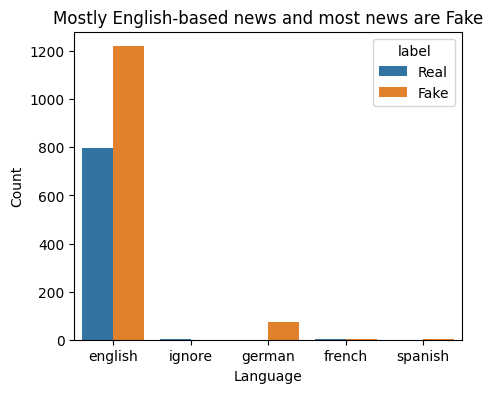

In [76]:
plt.figure( figsize= (5,4))
ax = sns.countplot(
    data = news_df_reordered_df ,
    x    = "language" ,
    hue  = "label" ,
)
ax.set_title("Mostly English-based news and most news are Fake")
ax.set(xlabel='Language', ylabel='Count')
#plt.savefig('c:\\ndsha_maps\\learning\\python\\DevAcademy\\Projects\\Week08_SupervisedLearning\\pictures\\languages_dist.jpg', dpi = 150)

Distribution of Fake vs Real

[Text(0, 0.5, 'Count')]

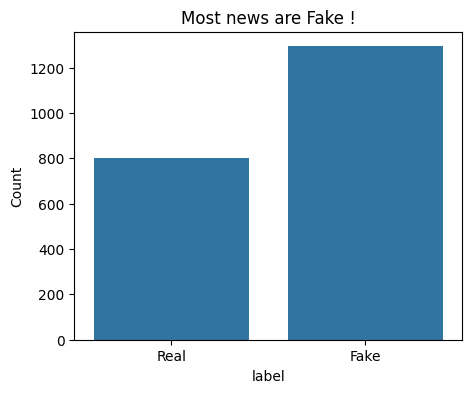

In [77]:
plt.figure( figsize= (5,4))
ax = sns.countplot(
    data = news_df_reordered_df ,
    x = "label" ,
)
ax.set_title("Most news are Fake !")
ax.set( ylabel='Count')
# plt.savefig('c:\\ndsha_maps\\learning\\python\\DevAcademy\\Projects\\Week08_SupervisedLearning\\pictures\\fakeVSreal_dist.jpg', dpi = 150)

 Real and Categories

[Text(0.5, 0, 'News categories in the dataset'), Text(0, 0.5, 'Count')]

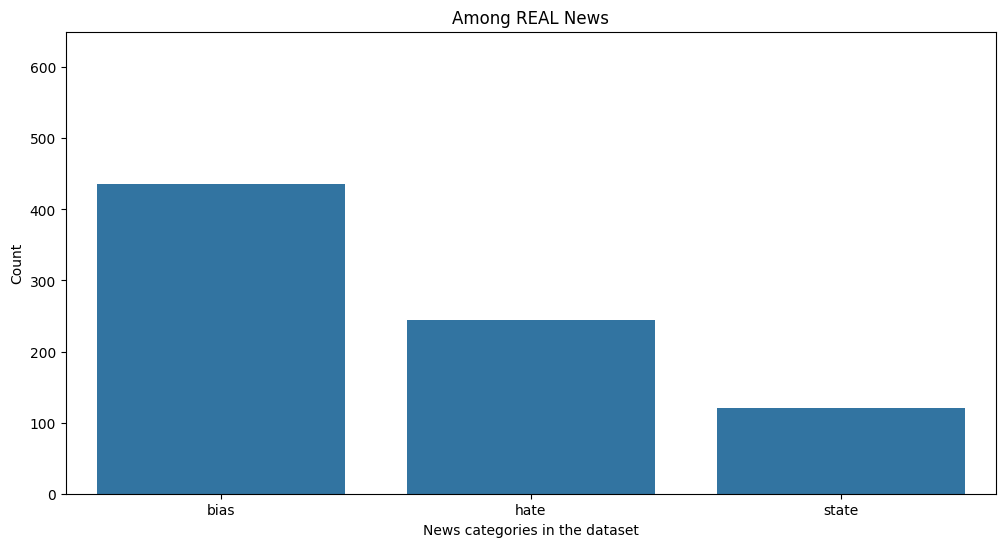

In [78]:
plt.figure( figsize= (12,6))
ax = sns.countplot(
    data = news_df_reordered_df[news_df_reordered_df["label"] == "Real" ] ,
    x = "type" ,
)
ax.set_ylim(0, 650 )
ax.set_title("Among REAL News")
ax.set( xlabel = "News categories in the dataset",  ylabel='Count')

 Fake and Categories

[Text(0.5, 0, 'News categories in the dataset'), Text(0, 0.5, 'Count')]

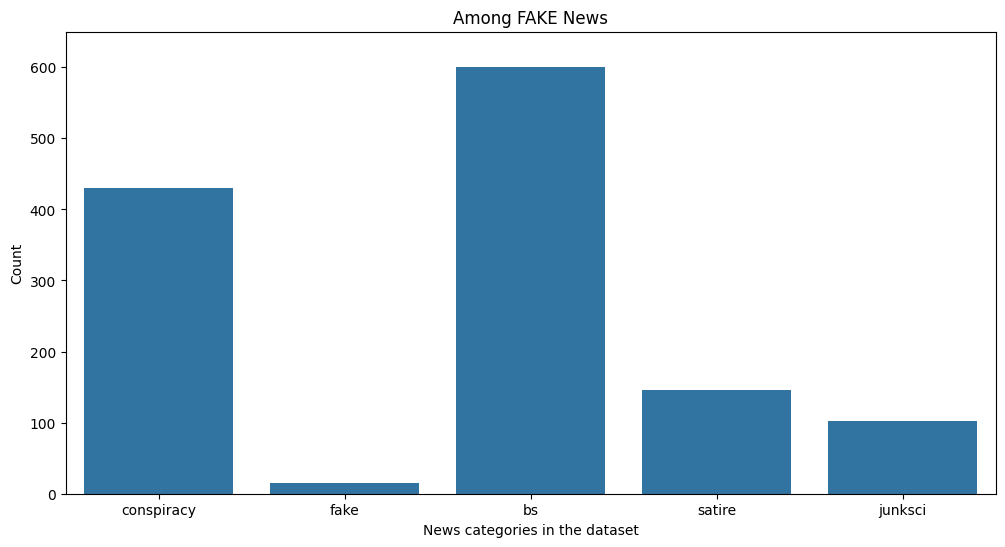

In [79]:
plt.figure( figsize= (12,6))
ax = sns.countplot(
    data = news_df_reordered_df[news_df_reordered_df["label"] == "Fake" ] ,
    x = "type" ,
)
ax.set_ylim(0, 650 )
ax.set_title("Among FAKE News")
ax.set( xlabel = "News categories in the dataset",  ylabel='Count')
# plt.savefig('c:\\ndsha_maps\\learning\\python\\DevAcademy\\Projects\\Week08_SupervisedLearning\\pictures\\Fake_vs_type.jpg', dpi = 150)

# Top 10 news presenting Fake news ###

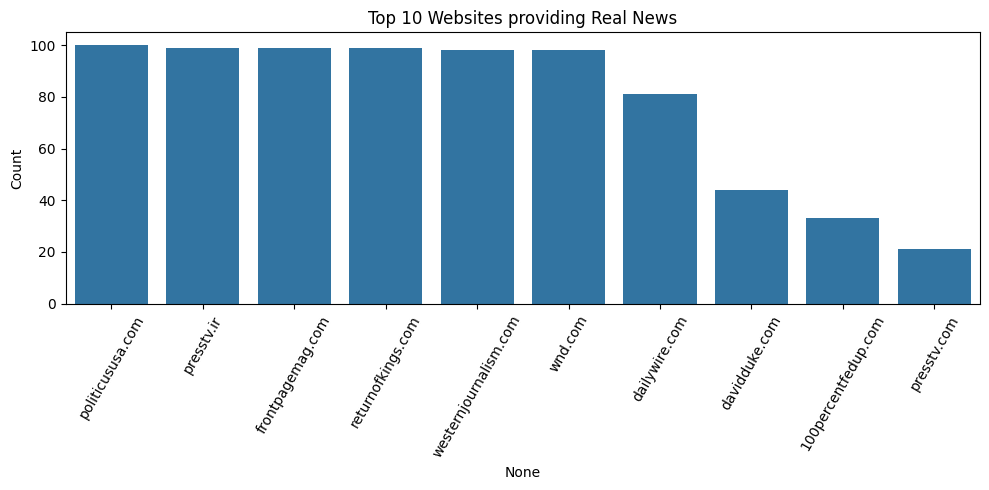

In [80]:
plt.figure(figsize= (10,5))
news_real_df = news_df_reordered_df[news_df_reordered_df["label"] == "Real"]["site_url"].value_counts().head(10)
ax = sns.barplot(
    x = news_real_df.index ,
    y = news_real_df.values
)
plt.xticks(rotation=60)
ax.set_title("Top 10 Websites providing Real News")
ax.set( ylabel='Count')
plt.tight_layout()

# Top 10 news presenting Real news ###

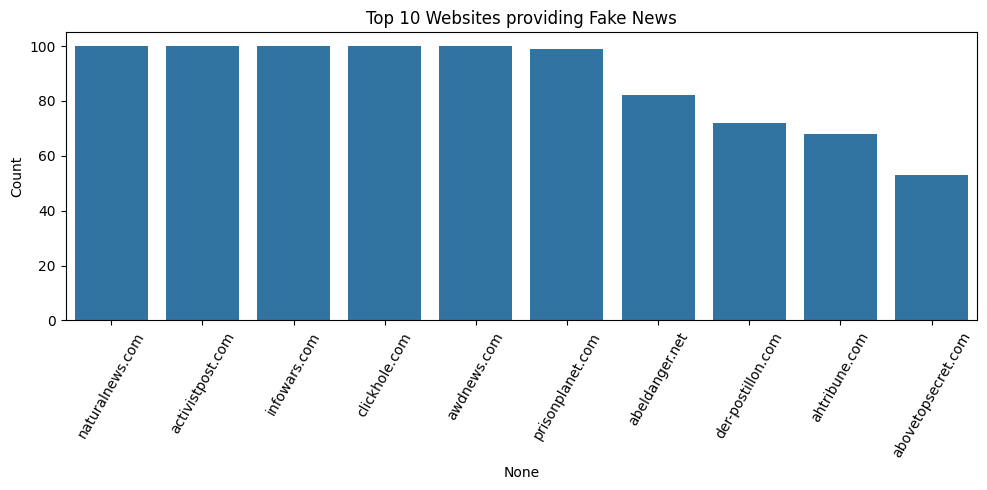

In [81]:
plt.figure(figsize= (10,5))
news_fake_df = news_df_reordered_df[news_df_reordered_df["label"] == "Fake"]["site_url"].value_counts().head(10)
ax = sns.barplot(
    x = news_fake_df.index ,
    y = news_fake_df.values
)
plt.xticks(rotation=60)
ax.set_title("Top 10 Websites providing Fake News")
ax.set( ylabel='Count')
plt.tight_layout()


# Which type of news article have images ###

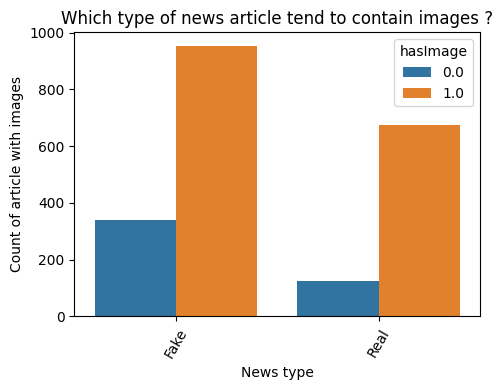

In [82]:
plt.figure(figsize= (5,4))
news_image_df = news_df_reordered_df[["label","hasImage"]].reset_index().groupby(["label","hasImage"]).count().reset_index()

news_image_df
palette = ["#FFCC33", "#CC6633", "#CCFFFF", "#0000FF"]
ax = sns.barplot(
    data = news_image_df ,
    x = "label" ,
    hue = "hasImage" ,
    y = "index"
)
plt.xticks(rotation=60)
ax.set_title("Which type of news article tend to contain images ?")
ax.set( xlabel = "News type" ,  ylabel='Count of article with images')
plt.tight_layout()

# Which words appear the most often ?

In [83]:
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

In [85]:
news_rm_na_df = news_df_reordered_df.dropna()

def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

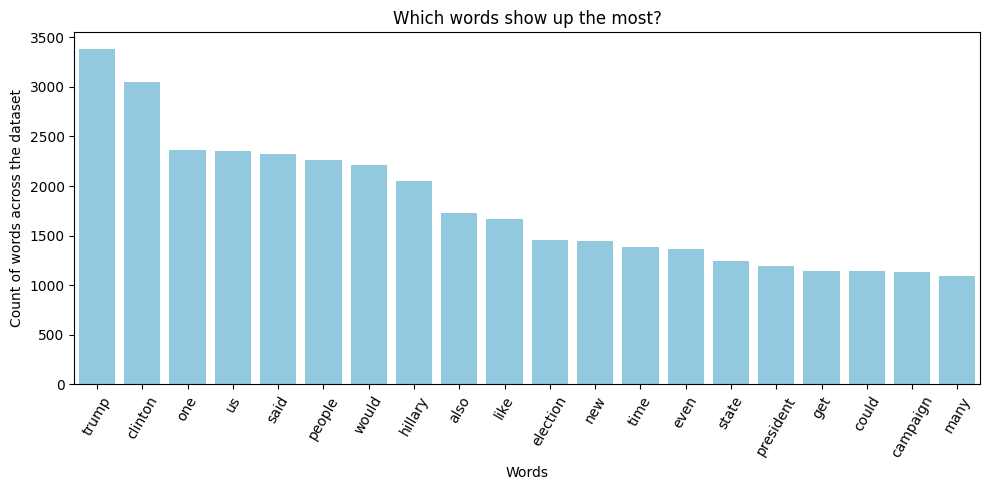

In [86]:
common_words = get_top_n_words(news_rm_na_df['text_without_stopwords'], 20)
#type(common_words)
common_words_df = pd.DataFrame (common_words,columns=['word','count'])
plt.figure(figsize= (10,5))
ax = sns.barplot(
    x = common_words_df["word"]  ,
    y = common_words_df["count"] ,
    color = "skyblue"
)
plt.xticks(rotation=60)
ax.set_title("Which words show up the most?")
ax.set( xlabel = "Words" ,  ylabel='Count of words across the dataset')
plt.tight_layout()

#      DATASET PRE-PROCESSING

##  Which columns :

 Source and content are connected in determining whether its a FakeNews or not, hence we combine them in one column

In [88]:
news_rm_na_df["site_url_text"] =  news_rm_na_df["site_url"] + " " + news_rm_na_df["text"]
news_eda_df = news_rm_na_df.drop( columns= ["title_without_stopwords","text_without_stopwords"] )

news_eda_df

<ipython-input-88-50ad95806055>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_rm_na_df["site_url_text"] =  news_rm_na_df["site_url"] + " " + news_rm_na_df["text"]


,author,published,site_url,main_img_url,language,type,hasImage,title,text,label,site_url_text
0,Barracuda Brigade,2016-10-26T21:41:00.000+03:00,100percentfedup.com,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,english,bias,1.0,muslims busted they stole millions in govt ben...,print they should pay all the back all the mon...,Real,100percentfedup.com print they should pay all ...
1,reasoning with facts,2016-10-29T08:47:11.259+03:00,100percentfedup.com,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,english,bias,1.0,re why did attorney general loretta lynch plea...,why did attorney general loretta lynch plead t...,Real,100percentfedup.com why did attorney general l...
2,Barracuda Brigade,2016-10-31T01:41:49.479+02:00,100percentfedup.com,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,english,bias,1.0,breaking weiner cooperating with fbi on hillar...,red state \nfox news sunday reported this mor...,Real,100percentfedup.com red state \nfox news sund...
3,Fed Up,2016-11-01T05:22:00.000+02:00,100percentfedup.com,http://100percentfedup.com/wp-content/uploads/...,english,bias,1.0,pin drop speech by father of daughter kidnappe...,email kayla mueller was a prisoner and torture...,Real,100percentfedup.com email kayla mueller was a ...
4,Fed Up,2016-11-01T21:56:00.000+02:00,100percentfedup.com,http://100percentfedup.com/wp-content/uploads/...,english,bias,1.0,fantastic trumps point plan to reform healthc...,email healthcare reform to make america great ...,Real,100percentfedup.com email healthcare reform to...
...,...,...,...,...,...,...,...,...,...,...,...
2041,Matt Barber,2016-10-27T03:04:50.327+03:00,wnd.com,No Image URL,english,bias,0.0,why never trumpers must reconsider,prof canoes reek of genocide white privilege c...,Real,wnd.com prof canoes reek of genocide white pri...
2042,Jane Chastain,2016-10-27T03:04:50.704+03:00,wnd.com,No Image URL,english,bias,1.0,election crossroads socialism or capitalism,teens walk free after gangrape conviction judg...,Real,wnd.com teens walk free after gangrape convict...
2043,Michael Brown,2016-10-27T03:04:54.788+03:00,wnd.com,http://mobile.wnd.com/files/2011/12/leftfield3...,english,bias,1.0,reasons ill vote for trump,school named for munichmassacre mastermind ter...,Real,wnd.com school named for munichmassacre master...
2044,Ann Coulter,2016-10-27T03:05:01.989+03:00,wnd.com,http://www.wnd.com/files/2016/10/danney-willll...,english,bias,1.0,our new country women and minorities hit hardest,wars and rumors of wars russia unveils satan ...,Real,wnd.com wars and rumors of wars russia unveils...


In [89]:
Lenc = LabelEncoder()
y = Lenc.fit_transform(news_eda_df["label"])
X = news_eda_df["site_url_text"]

In [90]:
X_train, X_test, y_train , y_test = train_test_split( X ,y , test_size=0.30 , stratify= y)

 Verify stratify proportion

In [91]:
print( "original dataset proportion:\n", (news_eda_df.label.value_counts(normalize=True)*100).round( decimals =2 ))
print( "\nTEST dataset proportion:\n" ,(pd.Series(y_test).value_counts( normalize=True)*100).round(decimals=2) )
print( "\nTRAIN dataset proportion:\n" ,(pd.Series(y_train).value_counts( normalize=True)*100).round(decimals=2) )

original dataset proportion:
 Fake    63.13
Real    36.87
Name: label, dtype: float64

TEST dataset proportion:
 0    63.19
1    36.81
dtype: float64

TRAIN dataset proportion:
 0    63.1
1    36.9
dtype: float64


#  Bag-of-Words



 1a) TF-IDF method to handle words

In [94]:
word_vectorizer  = TfidfVectorizer(stop_words = 'english')
tfidf_train      = word_vectorizer.fit_transform( X_train)
tfidf_test       = word_vectorizer.transform(X_test)
tfidf_df         = pd.DataFrame(tfidf_train.A , columns= word_vectorizer.get_feature_names_out()  )

In [98]:
print("dimensions of word vec output:\n" , word_vectorizer.idf_.shape, "\n")

# How does the output of a word vectoriser look like ?
list(word_vectorizer.idf_)[:5]

dimensions of word vec output:
 (39048,) 



[5.131333131591441,
 5.222304909797168,
 7.573680166960646,
 6.657389435086491,
 7.573680166960646]

First 10 rows and how the table TermFrequency-InverseDocumentFrequency (Tfidf)looks like

In [99]:
tfidf_df.head(5)
tfidf_df.iloc[900:910,30150:30160]

,saucers,sauces,sauchlemuir,saud,saudi,saudia,saudiallies,saudibacked,saudiled,saudis
900,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
901,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
902,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
903,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
904,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
905,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
906,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
907,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
908,0.0,0.0,0.0,0.0,0.027055,0.0,0.0,0.0,0.0,0.0
909,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


In [100]:
print(tfidf_train.shape)
print(tfidf_test.shape)

(1431, 39048)
(614, 39048)


#      ML MODELS  -----   ML MODELS


###  1) RANDOM FOREST CLASSIFIER

 LONG Approach : this requires to have preprocessed the data (tokenised etc BEFORE the step below)

In [120]:
rfc     = RandomForestClassifier(n_estimators=100,random_state=0)
rfc.fit(tfidf_train, y_train)

RandomForestClassifier(random_state=0)

In [121]:
y_pred  = rfc.predict(tfidf_test )
RFscore = metrics.accuracy_score(y_test, y_pred)
print("The accuracy is :", RFscore.round(2)*100 ,"%")

The accuracy is : 92.0 %


In [122]:
print("test:" , y_test.shape)
print("prediction:" ,y_pred.shape)

test: (614,)
prediction: (614,)


In [123]:
pd.DataFrame({ "Actual" : y_test , "Predicted" : y_pred } ).head(5)

,Actual,Predicted
0,1,0
1,0,0
2,0,0
3,1,1
4,0,0


In [124]:
print(metrics.classification_report( y_test , y_pred ))

              precision    recall  f1-score   support

           0       0.90      0.98      0.94       388
           1       0.95      0.82      0.88       226

    accuracy                           0.92       614
   macro avg       0.93      0.90      0.91       614
weighted avg       0.92      0.92      0.92       614



Text(0.5, 1.0, 'Confusion Matrix for RF Classifier')

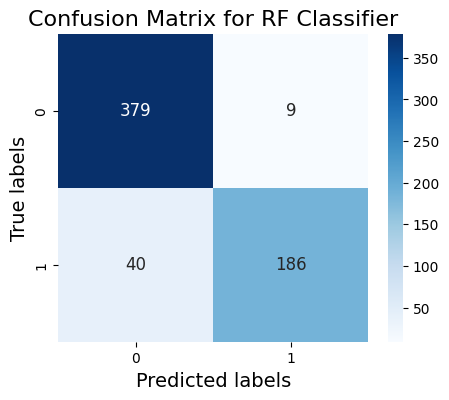

In [125]:
# Confusion Matrix

cm = metrics.confusion_matrix(y_test , y_pred )
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", annot_kws={"fontsize": 12})
plt.xlabel('Predicted labels', fontsize=14)
plt.ylabel('True labels', fontsize=14)
plt.title('Confusion Matrix for RF Classifier', fontsize=16)
# plt.savefig('c:\\DevAcademy\\Projects\\Week08_SupervisedLearning\\pictures\\RFC_matrix.jpg', dpi = 150)

As there are quite a few algorithms to cover hereafter, I opted for a shorter process and tested it with RF again before moving to the next ML algorithms. I tried with a PIPELINE which does both the Tf-Idf vectoriser and the ML algorithm in shorter lines of code as below. The pipeline is to be applied to the data right after Train/Test split.

In [128]:
pipeline = Pipeline([
  ( "word_vectorizer" , TfidfVectorizer(stop_words = 'english' )  ) ,
  #
  ( "rfc" , RandomForestClassifier( n_estimators =100 , random_state = 0)  )
])

In [129]:
pipeline.fit( X_train , y_train)

Pipeline(steps=[('word_vectorizer', TfidfVectorizer(stop_words='english')),
                ('rfc', RandomForestClassifier(random_state=0))])

In [130]:
y_pred  = pipeline.predict(X_test )
RFscore_pipeline = metrics.accuracy_score(y_test, y_pred)

In [117]:
print("The accuracy is :", RFscore_pipeline.round(2)*100 , "%\n")
print(metrics.classification_report( y_test , y_pred ))

The accuracy is : 92.0 %

              precision    recall  f1-score   support

           0       0.90      0.98      0.94       388
           1       0.95      0.82      0.88       226

    accuracy                           0.92       614
   macro avg       0.93      0.90      0.91       614
weighted avg       0.92      0.92      0.92       614



Text(0.5, 1.0, 'Confusion Matrix for RF using pipeline')

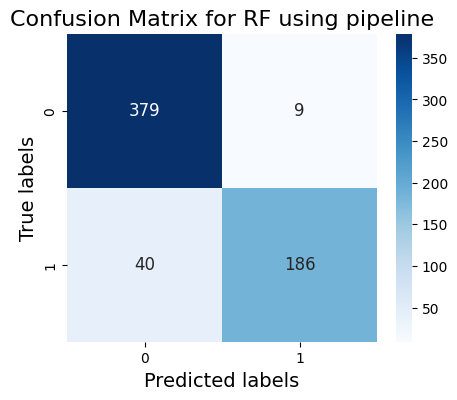

In [132]:
# Confusion Matrix with Pipeline RF
cm = metrics.confusion_matrix(y_test , y_pred )
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", annot_kws={"fontsize": 12})
plt.xlabel('Predicted labels', fontsize=14)
plt.ylabel('True labels', fontsize=14)
plt.title('Confusion Matrix for RF using pipeline', fontsize=16)


# The results should be the same as when I fitted the algo without the pipeline, which it is :) !

### 3) USING LOGISTIC REGRESSION

In [133]:
pipeline = Pipeline([
  ( "word_vectorizer" , TfidfVectorizer(stop_words = 'english' )  ) ,
  #
  ( "logreg" , LogisticRegression()  )
])

In [134]:
pipeline.fit( X_train     , y_train)

Pipeline(steps=[('word_vectorizer', TfidfVectorizer(stop_words='english')),
                ('logreg', LogisticRegression())])

In [135]:
y_pred  = pipeline.predict(X_test )
LRscore_pipeline = metrics.accuracy_score(y_test, y_pred)

In [136]:
print("The accuracy is: ", LRscore_pipeline.round(2)*100 , "%\n")
print(metrics.classification_report( y_test , y_pred ))

The accuracy is:  77.0 %

              precision    recall  f1-score   support

           0       0.74      0.97      0.84       388
           1       0.88      0.42      0.57       226

    accuracy                           0.77       614
   macro avg       0.81      0.69      0.70       614
weighted avg       0.79      0.77      0.74       614



 Confusion Matrix with Pipeline LR

Text(0.5, 1.0, 'Confusion Matrix for Logistic Regression')

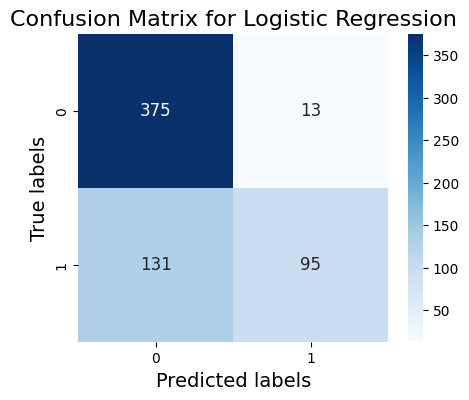

In [138]:
# Confusion Matrix with Pipeline LR

cm = metrics.confusion_matrix(y_test , y_pred )
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", annot_kws={"fontsize": 12})
plt.xlabel('Predicted labels', fontsize=14)
plt.ylabel('True labels', fontsize=14)
plt.title('Confusion Matrix for Logistic Regression', fontsize=16)

###  3) DECISION TREE

In [139]:
pipeline = Pipeline([
  ( "word_vectorizer" , TfidfVectorizer(stop_words = 'english' )  ) ,
  #
  ( "dectree"         , DecisionTreeClassifier()  )
])

In [140]:
pipeline.fit( X_train     , y_train)

Pipeline(steps=[('word_vectorizer', TfidfVectorizer(stop_words='english')),
                ('dectree', DecisionTreeClassifier())])

In [141]:
y_pred  = pipeline.predict(X_test )
DTscore_pipeline = metrics.accuracy_score(y_test, y_pred)

In [142]:
print("The accuracy is: ", DTscore_pipeline.round(2)*100 , "%\n" )
print(metrics.classification_report( y_test , y_pred ))

The accuracy is:  100.0 %

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       388
           1       0.99      1.00      1.00       226

    accuracy                           1.00       614
   macro avg       1.00      1.00      1.00       614
weighted avg       1.00      1.00      1.00       614



Text(0.5, 1.0, 'Confusion Matrix for Decision Tree')

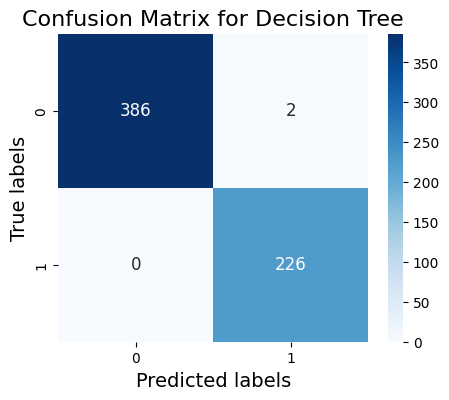

In [143]:
# Confusion Matrix with Pipeline DT
cm = metrics.confusion_matrix(y_test , y_pred )
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", annot_kws={"fontsize": 12})
plt.xlabel('Predicted labels', fontsize=14)
plt.ylabel('True labels', fontsize=14)
plt.title('Confusion Matrix for Decision Tree', fontsize=16)


  ### 4) NAIVE BAYES

In [144]:
pipeline = Pipeline([
  ( "word_vectorizer" , TfidfVectorizer(stop_words = 'english' )  ) ,
  #
  ( "naivebayes"      , MultinomialNB()  )
])

In [145]:
pipeline.fit( X_train     , y_train)

Pipeline(steps=[('word_vectorizer', TfidfVectorizer(stop_words='english')),
                ('naivebayes', MultinomialNB())])

In [146]:
y_pred  = pipeline.predict(X_test )
NBscore_pipeline = metrics.accuracy_score(y_test, y_pred)

In [147]:
print("The accuracy is:", NBscore_pipeline , "%\n")
print(metrics.classification_report( y_test , y_pred ))

The accuracy is: 0.6856677524429967 %

              precision    recall  f1-score   support

           0       0.67      0.99      0.80       388
           1       0.95      0.15      0.27       226

    accuracy                           0.69       614
   macro avg       0.81      0.57      0.53       614
weighted avg       0.77      0.69      0.60       614



Text(0.5, 1.0, 'Confusion Matrix for Naive Bayes')

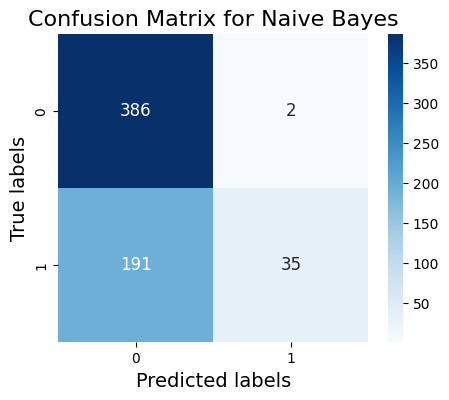

In [148]:
# Confusion Matrix with Pipeline NB
cm = metrics.confusion_matrix(y_test , y_pred )
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", annot_kws={"fontsize": 12})
plt.xlabel('Predicted labels', fontsize=14)
plt.ylabel('True labels', fontsize=14)
plt.title('Confusion Matrix for Naive Bayes', fontsize=16)

 ### 5) SUPPORT VECTOR MACHINES

In [149]:
pipeline = Pipeline([
  ( "word_vectorizer" , TfidfVectorizer(stop_words = 'english' )  ) ,
  #
  ( "svm"      , svm.SVC(gamma='auto')  )
])

In [150]:
pipeline.fit( X_train     , y_train)

Pipeline(steps=[('word_vectorizer', TfidfVectorizer(stop_words='english')),
                ('svm', SVC(gamma='auto'))])

In [151]:
y_pred  = pipeline.predict(X_test )
SVMscore_pipeline = metrics.accuracy_score(y_test, y_pred)

In [154]:
print("The accuracy is :", SVMscore_pipeline.round(2)*100 , "%\n")
print(metrics.classification_report( y_test , y_pred ))

The accuracy is : 63.0 %

              precision    recall  f1-score   support

           0       0.63      1.00      0.77       388
           1       0.00      0.00      0.00       226

    accuracy                           0.63       614
   macro avg       0.32      0.50      0.39       614
weighted avg       0.40      0.63      0.49       614



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(0.5, 1.0, 'Confusion Matrix for SVM')

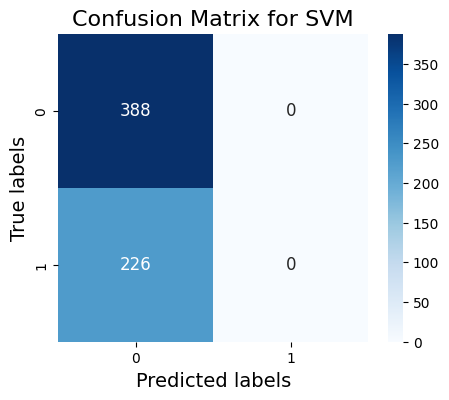

In [155]:
# Confusion Matrix with Pipeline SVM
cm = metrics.confusion_matrix(y_test , y_pred )
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", annot_kws={"fontsize": 12})
plt.xlabel('Predicted labels', fontsize=14)
plt.ylabel('True labels', fontsize=14)
plt.title('Confusion Matrix for SVM', fontsize=16)

###   5) WORD EMBEDDING + ANN

In [156]:
vocab_size = 10000
oov_token = "<OOV>"
embedding_dim = 32
max_length = 120
padding = 'post'
trunc_type = 'post'

In [157]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token = oov_token)
tokenizer.fit_on_texts(X_train)

In [158]:
training_sequences = tokenizer.texts_to_sequences(X_train)
testing_sequences  = tokenizer.texts_to_sequences(X_test)
print(len(training_sequences))
print(len(testing_sequences))


train_padded = pad_sequences(training_sequences, maxlen = max_length, padding = 'post', truncating = trunc_type)
test_padded  = pad_sequences(testing_sequences, maxlen = max_length, padding = 'post', truncating = trunc_type)

1431
614


In [159]:
print(train_padded.shape)
print(test_padded.shape)

(1431, 120)
(614, 120)


## Create Keras MOdel

In [160]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 120, 32)           320000    
                                                                 
 flatten (Flatten)           (None, 3840)              0         
                                                                 
 dense (Dense)               (None, 1)                 3841      
                                                                 
Total params: 323841 (1.24 MB)
Trainable params: 323841 (1.24 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [161]:
num_epochs = 10
history = model.fit(train_padded, y_train, epochs = num_epochs, validation_data = (test_padded, y_test))

Epoch 1/10
45/45 [==============================] - 2s 20ms/step - loss: 0.6652 - accuracy: 0.6289 - val_loss: 0.6195 - val_accuracy: 0.6352
Epoch 2/10
45/45 [==============================] - 0s 8ms/step - loss: 0.5200 - accuracy: 0.7170 - val_loss: 0.4906 - val_accuracy: 0.7296
Epoch 3/10
45/45 [==============================] - 0s 8ms/step - loss: 0.3338 - accuracy: 0.9832 - val_loss: 0.3391 - val_accuracy: 0.9642
Epoch 4/10
45/45 [==============================] - 0s 9ms/step - loss: 0.1801 - accuracy: 0.9944 - val_loss: 0.2292 - val_accuracy: 0.9870
Epoch 5/10
45/45 [==============================] - 0s 8ms/step - loss: 0.0993 - accuracy: 0.9972 - val_loss: 0.1684 - val_accuracy: 0.9886
Epoch 6/10
45/45 [==============================] - 0s 8ms/step - loss: 0.0609 - accuracy: 0.9979 - val_loss: 0.1344 - val_accuracy: 0.9886
Epoch 7/10
45/45 [==============================] - 0s 9ms/step - loss: 0.0412 - accuracy: 0.9986 - val_loss: 0.1138 - val_accuracy: 0.9870
Epoch 8/10
45/45 [=

In [173]:
print("The Training Accuracy is: ", round(history.history['accuracy'][9]*100, 2)   , "%")
print("The Testing Accuracy  is: ", round(history.history['val_accuracy'][9]*100,2), "%")

The Training Accuracy is:  99.86 %
The Testing Accuracy  is:  98.7 %


In [163]:
y_pred_ann = model.predict(test_padded)

20/20 [==============================] - 0s 2ms/step


In [174]:
y_pred_ann = np.where(y_pred_ann > 0.5 , 1 , 0)
y_pred_ann[:3]

array([[1],
       [0],
       [0]])

In [176]:
print("test values:" ,y_test[:3])
print("predicted values:" , y_pred_ann[:3].T)

test values: [1 0 0]
predicted values: [[1 0 0]]


In [177]:
print(y_test.shape)
print(y_pred_ann.shape)

(614,)
(614, 1)


In [178]:
cm = metrics.confusion_matrix(y_test , y_pred_ann.flatten() )
cm

array([[383,   5],
       [  3, 223]])

Text(0.5, 1.0, 'Confusion Matrix for ANN')

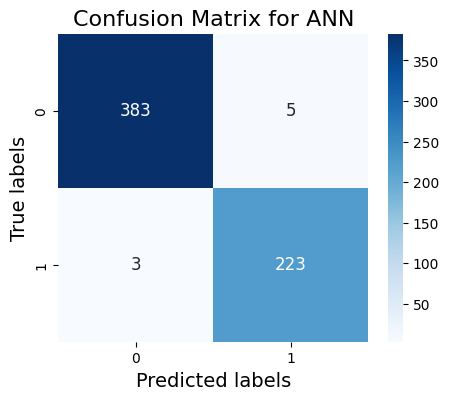

In [179]:
cm = metrics.confusion_matrix(y_test , y_pred_ann )
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", annot_kws={"fontsize": 12})
plt.xlabel('Predicted labels', fontsize=14)
plt.ylabel('True labels', fontsize=14)
plt.title('Confusion Matrix for ANN', fontsize=16)